# Wines

In [1]:
# import
from IPython.display import display, clear_output
import os
import seaborn as sns
import pandas as pd
import numpy as np
from importlib import reload
import requests
import random
import pickle
import time
import matplotlib.pyplot as plt
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import confusion_matrix

from scipy.spatial.distance import cosine
from nltk.corpus import words
import gensim

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from collections import Counter
%matplotlib inline
from wine_and_cheese_utils import WineList, df_columns, regexp_tokenizer

import warnings
    
warnings.filterwarnings("ignore")

In [2]:
# create the wine list object (will load the .csv file)
wl = WineList(file='cleaned')
model = Doc2Vec.load('doc2vec_on_region_1_no_region_variety_full_dataset.model')

In [3]:
input_str = 'Grenache'
column_name = 'variety'


input_str = input_str.lower()

# any([(input_str in this_column_str.lower()) for this_column_str in set(wl.df[column_name])])
# wl.is_in_column(input_str,"region_1")
# input_str.lower() in [x.lower() for x in set(wl.df[column_name])]
# set(wl.df[column_name])

# %timeit wl.is_in_column(input_str,column_name)
wl.tokenize('sour grenache sweet')


['sour', 'grenache', 'sweet']

In [6]:
# 'grenache' in set()
wl.get_match_dict('sour grenache sweet lime white peach',model)

{'description': ['sour', 'grenache', 'sweet', 'lime', 'white', 'peach'],
 'region_1': ['sour', 'lime'],
 'variety': ['grenache', 'white']}

In [8]:
desc = ['sour', 'grenache', 'sweet', 'lime', 'white', 'peach']
cond = wl.df.description.str.contains(desc[0])




# add the regions and varieties to stop words
wl.get_region_variety_stop_words()
# wl.stop_words.all

SyntaxError: invalid syntax (<ipython-input-8-9aa8ee11ba4c>, line 1)

In [101]:
import timeit
titwl.df.region_1[wl.df.region_1.str.contains("cote",case=False)]

338                Coteaux Varois en Provence
356                                 Heathcote
552                 Coteaux d'Aix-en-Provence
704                 Coteaux d'Aix-en-Provence
741                      Coteaux Bourguignons
1339               Coteaux Varois en Provence
1432                Coteaux d'Aix-en-Provence
2111                Coteaux d'Aix-en-Provence
3603                     Coteaux du Languedoc
3736                Coteaux d'Aix-en-Provence
4197                Coteaux d'Aix-en-Provence
4430               Coteaux Varois en Provence
5241                      Coteaux du Giennois
5746                Coteaux d'Aix-en-Provence
7134      Coteaux du Languedoc Pic Saint Loup
7972                Coteaux d'Aix-en-Provence
7990                           Coteaux Varois
8265                Coteaux d'Aix-en-Provence
9439                  Coteaux du Layon Chaume
9849                     Coteaux Bourguignons
10053              Coteaux Varois en Provence
10605                          Cot

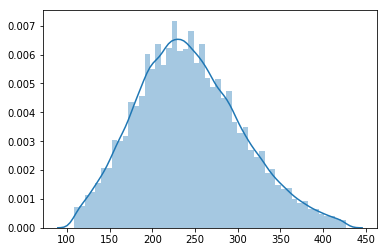

In [3]:
sns.distplot(wl.df.description.str.len().tolist())

In [74]:
print(np.percentile(wl.df.description.str.len().tolist(),2))
print(np.percentile(wl.df.description.str.len().tolist(),98))

121.0
399.0


In [78]:
len(wl.df)


97419

## A few examples of tokenized pooled descriptions
We pool all the descriptions of wines from a given region and and look at the 50 most common tokens for it

In [5]:
print(wl.get_counter(wl.df[wl.df.region_1=='Cahors'].description.str.cat(sep=" "),tokenize=True).most_common(50))

[('wine', 659), ('tannins', 336), ('drink', 274), ('fruits', 246), ('fruit', 215), ('acidity', 168), ('ripe', 152), ('rich', 136), ('wood', 126), ('dense', 124), ('dark', 123), ('aging', 123), ('flavors', 120), ('firm', 115), ('age', 99), ('structure', 99), ('years', 98), ('juicy', 96), ('still', 92), ('powerful', 92), ('concentrated', 84), ('well', 84), ('character', 80), ('texture', 78), ('2018.', 76), ('fruity', 75), ('young', 71), ('structured', 70), ('solid', 67), ('plum', 61), ('full', 61), ('berry', 60), ('ready', 55), ('soft', 53), ('tannic', 52), ('give', 51), ('blackberry', 51), ('balanced', 49), ('needs', 46), ('generous', 44), ('2019.', 44), ('smooth', 44), ('2017.', 42), ('fruitiness', 41), ('spice', 40), ('impressive', 38), ('estate', 37), ('packed', 36), ('perfumed', 35), ('2020.', 35)]


In [6]:
print(wl.get_counter(wl.df[wl.df.region_1=='Pouilly-Fuissé'].description.str.cat(sep=" "),tokenize=True).most_common(25))

[('wine', 331), ('acidity', 157), ('drink', 156), ('ripe', 121), ('flavors', 100), ('rich', 95), ('fruits', 92), ('fruit', 88), ('texture', 83), ('crisp', 81), ('yellow', 59), ('full', 58), ('mineral', 58), ('wood', 54), ('character', 51), ('spice', 51), ('fresh', 47), ('soft', 47), ('2017.', 43), ('well', 41), ('ready', 39), ('attractive', 37), ('fruity', 35), ('toast', 35), ('tight', 34)]


In [7]:
print(wl.get_counter(wl.df[wl.df.region_1=='Champagne'].description.str.cat(sep=" "),tokenize=True).most_common(25))

[('wine', 1479), ('acidity', 753), ('drink', 677), ('crisp', 575), ('ripe', 558), ('flavors', 519), ('fruit', 439), ('texture', 416), ('rich', 362), ('character', 334), ('soft', 321), ('ready', 315), ('fruits', 309), ('well', 299), ('age', 290), ('balanced', 278), ('full', 273), ('citrus', 260), ('tight', 254), ('fresh', 252), ('fruity', 244), ('mineral', 225), ('bottle', 212), ('aftertaste', 208), ('still', 195)]


# Can we predict the wine region based on its description?
We limit the analysis to the wines from the most frequent regions so thta we have about 80% of the data


In [27]:
# generate TaggedDocument object
column_name = 'region_1'
cum_sum_frac = 0.8
column_most_frequent, percentage = wl.get_most_frequent(column_name,cum_sum_frac=cum_sum_frac)
# pick the most common values for 'colum_name' amounting to about 80% of the dataset
sub_df = wl.df[wl.df[column_name].isin(column_most_frequent.index.tolist())]
print(percentage)

79.92287322412075


In [24]:
# We split the remaining data between training and test sets
train_frac = 0.66
train_df, test_df = wl.split_df(sub_df,train_frac)

In [ ]:
print(wl.df.iloc[0].description+" 12-13")
wl.tokenize(wl.df.iloc[0].description)


# print(row)
# tokenizer.tokenize(wl.df

In [41]:
for row in wl.df.loc[:10].itertuples():
    print(row.Index)

<built-in method index of Pandas object at 0x1192b8438>
<built-in method index of Pandas object at 0x1192b8a20>
<built-in method index of Pandas object at 0x1192b8438>
<built-in method index of Pandas object at 0x1192b8a20>
<built-in method index of Pandas object at 0x1192b8438>
<built-in method index of Pandas object at 0x1192b8a20>
<built-in method index of Pandas object at 0x1192b8438>
<built-in method index of Pandas object at 0x1192b8a20>


In [25]:
# collect the tagged document object
tagged_data = [TaggedDocument(words=wl.tokenize(row.description), tags=[row.Index]) for row in train_df.itertuples()]

In [43]:
tagged_data[:10]

[TaggedDocument(words=['tart', 'snappy', 'flavors', 'lime', 'flesh', 'rind', 'dominate', 'green', 'pineapple', 'pokes', 'crisp', 'acidity', 'underscoring', 'flavors', 'wine', 'stainless', 'steel', 'fermented'], tags=[2]),
 TaggedDocument(words=['much', 'like', 'regular', 'bottling', 'comes', 'across', 'rather', 'rough', 'tannic', 'rustic', 'earthy', 'herbal', 'characteristics', 'nonetheless', 'think', 'pleasantly', 'unfussy', 'country', 'wine', 'good', 'companion', 'hearty', 'winter', 'stew'], tags=[4]),
 TaggedDocument(words=['dry', 'restrained', 'wine', 'offers', 'spice', 'profusion', 'balanced', 'acidity', 'firm', 'texture', 'much', 'food'], tags=[7]),
 TaggedDocument(words=['soft', 'supple', 'plum', 'envelopes', 'oaky', 'structure', 'cabernet', 'supported', 'merlot', 'coffee', 'chocolate', 'complete', 'picture', 'finishing', 'strong', 'end', 'resulting', 'value', 'priced', 'wine', 'attractive', 'flavor', 'immediate', 'accessibility'], tags=[10]),
 TaggedDocument(words=['slightly', 

In [26]:
example = train_df[train_df.description.str.contains("Malbec")].iloc[0]
wl.tokenize(example.description)

['made',
 'equal',
 'parts',
 'small',
 'additions',
 'juicy',
 'reveals',
 'raisiny',
 'quality',
 'ripeness',
 'around',
 'integrated',
 'generous',
 'tannin']

In [8]:
retrain = True


column_name = 'region_1'
# load or train the model
model_file_name = 'doc2vec_on_{}pct_of_{:.1f}_stop_all.model'.format(column_name,percentage)

if not os.path.exists(model_file_name) or retrain:
    max_epochs = 20
    vec_size = 40
    alpha = 0.025

    model = Doc2Vec(vector_size=vec_size,
                    alpha=alpha, 
    #                 min_alpha=0.00025,
                    min_count=10,
                    dm =0)

    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        clear_output(wait=True)
        display('iteration {0}'.format(epoch))
        model.train(tagged_data,
                    total_examples=model.corpus_count,
                    epochs=model.epochs)
        # decrease the learning rate
        model.alpha -= 0.0002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save(model_file_name)
else:
    model = Doc2Vec.load(model_file_name)


'iteration 19'

In [ ]:
def wine_str(this_wine):
    returned_list =  [this_wine.title]
    returned_list.append("Variety: {}  / Region: {} ".format(this_wine.variety,this_wine.region_1))
    returned_list.append(this_wine.description)
    return returned_list

In [43]:
train_df.index[0]

2

In [62]:
# pick a random item in the test set
test_wine = test_df.sample(n=1)

new_desc = wl.tokenize(test_wine['description'].values[0],vocab=list(model.wv.vocab.keys()))
topn=50000
v1 = model.infer_vector(new_desc)
similar_doc = model.docvecs.most_similar([v1],topn=topn)
print("most similar wine has {}".format(similar_doc[0][1]))
print("{}th most similar wine has {}".format(topn,similar_doc[-1][1]))
print(test_wine.index[0])
wl.wine_str(test_wine)

most similar wine has 0.9394475221633911
50000th most similar wine has 0.15112987160682678
29709


['Lieb 2013 Reserve Sparkling Sparkling (North Fork of Long Island)',
 'Variety: Sparkling Blend  / Region: North Fork of Long Island ',
 "Forward and fruity, this bold, mouth-filling sparkling wine bursts of fleshy red cherries and raspberries. It's a cheerful blend of Chardonnay and Pinot Noir showcasing a blossomy, perfumed style and vibrant structure."]

In [63]:
print(similar_doc[0][0])
print(any(train_df.index==similar_doc[0][0]))
closest_wine = wl.df[wl.df.index==similar_doc[0][0]]
wl.wine_str(closest_wine)

29709
False


['Lieb 2013 Reserve Sparkling Sparkling (North Fork of Long Island)',
 'Variety: Sparkling Blend  / Region: North Fork of Long Island ',
 "Forward and fruity, this bold, mouth-filling sparkling wine bursts of fleshy red cherries and raspberries. It's a cheerful blend of Chardonnay and Pinot Noir showcasing a blossomy, perfumed style and vibrant structure."]

In [31]:
that_df = train_df[train_df.variety=='Pinot Noir']
# len(gamay_df)
# desc0 = wl.tokenizer(gamay_df.iloc[100].description)
# desc0
# desc1 = wl.tokenizer(gamay_df.iloc[101].description)
# desc1
# np.mean([model.infer_vector(desc0),model.infer_vector(desc1)],axis=0)

# descs = [ for x in gamay_df.sample(n=4).iterrows()]

def avg_doc2vec(df):
    return np.mean([model.infer_vector(wl.tokenize(row[1][1])) for row in df.iterrows()],axis=0)
                    
similar_docs = model.docvecs.most_similar([avg_doc2vec(that_df)],topn=20)
similar_docs

[(90609, 0.655677318572998),
 (64497, 0.6256648898124695),
 (9416, 0.6171138286590576),
 (79557, 0.6050858497619629),
 (126877, 0.5989450216293335),
 (69834, 0.5948544144630432),
 (101219, 0.589045524597168),
 (42945, 0.5829340219497681),
 (20499, 0.5711332559585571),
 (112795, 0.5698230266571045),
 (50924, 0.5621745586395264),
 (46504, 0.5538270473480225),
 (43269, 0.5528163313865662),
 (62836, 0.5519856214523315),
 (60696, 0.5515141487121582),
 (67877, 0.5507900714874268),
 (3119, 0.5492115020751953),
 (64831, 0.5484029650688171),
 (113407, 0.5471652746200562),
 (107156, 0.5469405055046082)]

In [35]:
wl.df.iloc[90609].description

"This fits the mold of Clare Valley Riesling perfectly. Struck flint notes give way to bright citrus on the nose, followed up by pineapple, cardamom and cinnamon flavors. It's dry to the point of austerity, framed by a slightly dusty texture, yet boasts mouthwatering acids on the long finish. Drink now–2025, possibly longer."

In [84]:
[str(wl.df.loc[x[0]][11]) + "---/--" + wl.df.loc[x[0]][1] for x in similar_docs]

["Sparkling Blend---/--A blend of 60% Chardonnay and 40% Pinot Nero, this delivers yellow apple, honeydew melon, passion fruit and citrus flavors. It's crisp and refreshing, with vibrant acidity and brisk bubbles.",
 'White Blend---/--A blend of Grillo, Catarratto and Inzolia, this vibrant wine opens with delicate aromas of white flower, tropical fruit and a hint of beeswax. On the palate, creamy white peach is energized by nectarine zest and crisp acidity.',
 'Champagne Blend---/--The Pinot Grigio brings its usual green apple, lemon curd, peach and mineral flavors to this zesty sparkling wine. It straddles the delicate border between dry and off-dry, and is easy to drink with almost anything.',
 'Pinot Grigio---/--Clean and zesty, this is a nice cocktail sipper, with rich flavors of green apples, pineapples, peaches, apricots, vanilla and spice. The honeyed finish is brightened with crisp acidity.',
 'Riesling---/--Hints of nut oil and smoke lend a savory tone to bright stone-fruit an

In [128]:
tokenized_desc = ['sweet','mineral','smooth']
similar_docs = model.docvecs.most_similar([model.infer_vector(tokenized_desc)],topn=10)
[str(wl.df.loc[x[0]][11]) + "---/--" + wl.df.loc[x[0]][1] for x in similar_docs]

["Pinot Gris---/--This wine is soft, rounded and smooth. With just enough acidity to give a fresh character, it is ripe with pear and quince flavors. It's ready to drink, light and fragrant.",
 'Chardonnay---/--This wine has a creamy, smooth character. Lightly buttery and with some ripe pear flavors, it is soft, refreshing and ready to drink.',
 'Sauvignon Blanc---/--The wine is soft and open. It has some bright citrus and creamed-apple flavors that give it a ripe character. The wine is juicy, fruity and ready to drink.',
 "Sauvignon Blanc---/--This is a ripe, fresh and fruity wine that's filled out with a tangy, mineral texture. Grapefruit and lime juice flavors give a zesty feel as well as intense acidity. It is ready to drink.",
 'Chardonnay---/--This tangy wine with spice and acidity has kiwi and lime flavors that give a fresh character. The aftertaste is lightly perfumed. Drink now.',
 'Chardonnay---/--Smooth and creamy, with mineral-infused pineapple crème brûlée, green apple but

In [72]:
def get_wines_from_desc(wl,input_str,model,topn=100):
    new_desc = wl.tokenize(input_str,vocab=list(model.wv.vocab.keys()))
    similar_docs = model.docvecs.most_similar([model.infer_vector(new_desc)],topn=topn)
    return [x[0] for x in similar_docs]

indexes = get_wines_from_desc(wl,'some light sweet white with pears notes',model,topn=10)
that_df.index.tolist()

[27088, 30073, 42134, 59168, 74807, 98667, 102049, 104157, 119461, 121710]

In [74]:
topn = 10

def tokens_in_description(row,tokenized_desc):
    return len(set(wl.tokenize(row.description)).intersection(tokenized_desc))>0

def all_tokens_in_description(tokenized_desc):
    condition = wl.df.apply(lambda x: tokens_in_description(x,tokenized_desc),axis=1)
    for token in tokenized_desc[1:]:
        condition = (condition) & (train_df.description.str.contains(token))
    return condition

In [89]:
tokenized_desc = ['lime','sweet','sour']

# wl.df.description.str.contains('lime') & wl.df.description.str.contains('sour')
wl.df[wl.df.variety.str.contains('gamay',case=False)]
# condition = train_df.apply(lambda x: tokens_in_description(x,tokenized_desc),axis=1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery


In [80]:
def get_closest_from_str(input_str,topn):
    closest_wines = pd.DataFrame()
#     new_desc = wl.tokenizer(test_wine['description'].values[0],vocab=list(model.wv.vocab.keys()),extra_stop=extra_stop)
    tokenized_desc = wl.tokenize(input_str)
    print(tokenized_desc)
    strict_df = train_df[all_tokens_in_description(tokenized_desc)]
    strict_res_len = len(strict_df)
    if strict_res_len>0:
        closest_wines=closest_wines.append(strict_df)
    return closest_wines, tokenized_desc, strict_res_len

In [85]:
closest_wines, tokenized_desc, strict_res_len  = get_closest_from_str(" ".join(tokenized_desc),topn)
print("found {} strict matches".format(strict_res_len))
for n in range(0,topn):
    [print(element) for element in wine_str(closest_wines.iloc[n])]
    print(" -----------   ")

['lime', 'sweet', 'sour', 'mineral', 'smooth']
found 1 strict matches
Monte del Frá NV Extra Dry Rosé Sparkling (Veneto)
Variety: Sparkling Blend  / Region: Veneto 
This is a cheerful and easygoing rosé sparkling wine that offers measured aromas of wild berry and chalky white mineral. The wine is creamy and smooth in the mouth and ends with a playful sweet-against sour-note. Made with Corvina and other grapes found near Verona.
 -----------   


IndexError: single positional indexer is out-of-bounds

In [62]:
wl.tokenize("Waxy and a touch volatile on the nose, this wine offers broad aromas of tropical fruit and barrel. The palate is lithe and medium bodied, bearing kiwi and papaya notes. It finishes with a minerally tang and vital acidity.")

['waxy',
 'touch',
 'volatile',
 'nose',
 'wine',
 'offers',
 'broad',
 'aromas',
 'tropical',
 'fruit',
 'barrel',
 'palate',
 'lithe',
 'medium',
 'bodied',
 'bearing',
 'kiwi',
 'papaya',
 'notes',
 'finishes',
 'minerally',
 'tang',
 'vital',
 'acidity']

In [70]:

# strict_df = train_df[all_tokens_in_description(tokenized_desc)]
# smoked_wines = train_df[condition]
# wine_str(smoked_wines.iloc[0])


'dry' in wl.stop_words.all

True

In [88]:
model.similar_by_word('acidity', topn=10)

[('acids', 0.8657336831092834),
 ('acid', 0.6513298153877258),
 ('viscosity', 0.6481216549873352),
 ('energy', 0.6352277994155884),
 ('bubbles', 0.6142082214355469),
 ('character', 0.611377477645874),
 ('alcohol', 0.5947938561439514),
 ('herbaceousness', 0.5937158465385437),
 ('enjoyment', 0.590045690536499),
 ('tension', 0.5786060094833374)]

In [150]:
far_away_wine = wl.df[wl.df.index==similar_doc[-1][0]]
# print(far_away_wine.index)
wine_str(far_away_wine)

['Lorenzi Estate 2009 Heritage Red Red (Temecula Valley)',
 'Variety: Red Blend  / Region: Temecula Valley ',
 'Austere tasting at first, this has a fruity, dusty flavor, with a swath of caramel.This blend of Merlot, Cabernet Sauvignon and Zinfandel tastes warm on the finish.']

In [223]:
wine_str(wl.df.loc[22])

['Baglio di Pianetto 2007 Ficiligno White (Sicilia)',
 'Variety: White Blend  / Region: Sicilia ',
 'Delicate aromas recall white flower and citrus. The palate offers passion fruit, lime and white peach with a hint of mineral alongside bright acidity.']

In [28]:
# checking if similarity predicts regions or variety
# n_dim = len(set(wl.df['region_1']))
y_true = []
y_pred = []
error_indexes = []
n_test = len(test_df)
cntr = 0
for test_wine in test_df.itertuples():
    cntr+=1
    if cntr%100==0:
        clear_output(wait=True)
        display('{0}% done'.format(cntr/n_test))
    new_desc = wl.tokenize(test_wine.description,vocab=list(model.wv.vocab.keys()))    
    v1 = model.infer_vector(new_desc)
    similar_doc = model.docvecs.most_similar([v1],topn=1)
    closest_wine = train_df[train_df.index==similar_doc[0][0]]
    try:
        y_pred.append(closest_wine[column_name].values[0])
        y_true.append(getattr(test_wine,column_name))
    except:
        error_indexes.append(test_wine[0])


'0.998952409458246% done'

In [14]:
len(error_indexes)/n_test

0.00942311259506585

In [22]:
column_most_frequent.index.tolist()

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Syrah',
 'Sauvignon Blanc',
 'Rosé',
 'Zinfandel',
 'Merlot',
 'Riesling',
 'Malbec',
 'Sangiovese',
 'Nebbiolo',
 'Sparkling Blend',
 'White Blend',
 'Tempranillo',
 'Rhône-style Red Blend',
 'Pinot Gris',
 'Cabernet Franc',
 'Champagne Blend',
 'Pinot Grigio',
 'Viognier',
 'Gewürztraminer']

In [29]:
conf_mat = confusion_matrix(y_true, y_pred, labels=column_most_frequent.index.tolist())

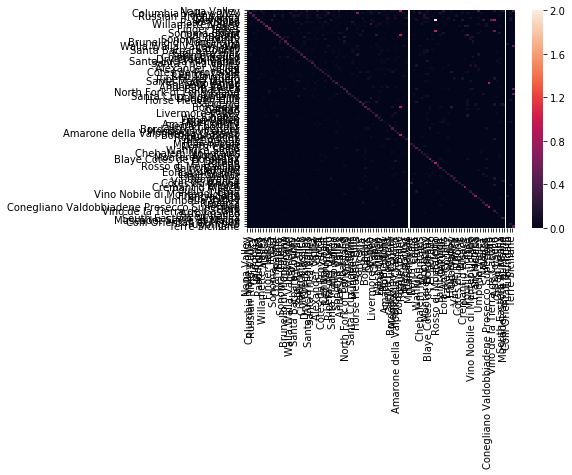

In [54]:
n_max = 100

norm_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)
sns.heatmap(norm_conf_mat[:n_max,:n_max])
plt.yticks(range(0,n_max), column_most_frequent.index.tolist()[:n_max], rotation='horizontal')
plt.xticks(range(0,n_max), column_most_frequent.index.tolist()[:n_max], rotation='vertical')
plt.show()

50.74336536998251


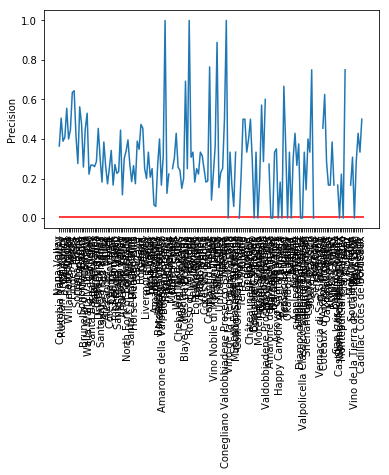

In [60]:
plt.plot(norm_conf_mat.diagonal())
print(np.nanmean(norm_conf_mat.diagonal())*len(column_most_frequent))
plt.hlines(1/len(column_most_frequent), xmin=0, xmax=len(column_most_frequent), colors='r')
plt.xticks(range(0,len(column_most_frequent)), column_most_frequent.index.tolist(), rotation='vertical')
plt.ylabel('Precision')
plt.title('')
plt.show()

'Syrah'

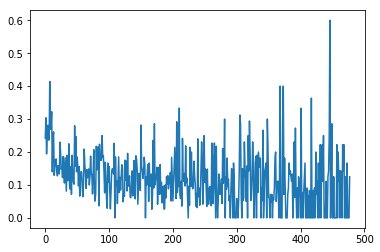

In [165]:
for n in range(0,30):
    if n%3==0:
        print(n)

0
3
6
9
12
15
18
21
24
27


28

In [ ]:
  
# tfidf = TfidfVectorizer(
#         analyzer='word',
#         tokenizer=lambda x : x,
#         preprocessor=lambda x : x,
#         token_pattern=None)
#         tfidf.fit(list(self.get_docs().values()))
#         return tfidf    
    
tfidf = TfidfVectorizer(
            analyzer='word',
            tokenizer=wl.tokenizer,
            max_features=1000,
            min_df=10,
        )

train_list = list(tfidf_dict['train'].values())
features = tfidf.fit_transform(train_list).toarray()

In [18]:
len(wl.df[wl.df.region_1.notnull()])/len(wl.df)

0.8365250709773718

In [33]:
len(wl.df[wl.df.region_1=="Pouilly-Fuissé"])

310

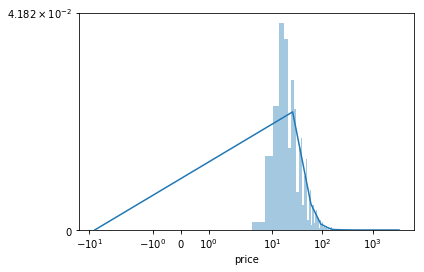

In [30]:
sns.distplot(wl.df.price[wl.df.price.notnull()],bins=1000)
plt.xscale('symlog')
plt.yscale('symlog')

In [129]:


labels = list(tfidf_dict['train'].keys())
# return tfidf, features, labels
vocab_list = list(tfidf.vocabulary_.keys())
# sorted_vocab = [(k,v) for k,v in tfidf.vocabulary_.items()]

In [ ]:
tokenized_full_list = wl.tokenizer(" ".join(train_list))

In [173]:
wl.stop_words.set.update(["make"])
wl.stop_words.save()
cntr = Counter(tokenized_full_list)
[print((k,v)) for k,v in cntr.most_common(300) if k not in wl.stop_words.all]

('fruit', 9051)
('aromas', 7443)
('palate', 7318)
('acidity', 7111)
('finish', 6925)
('tannins', 6497)
('cherry', 5824)
('ripe', 5595)
('black', 5295)
('red', 3914)
('spice', 3846)
('oak', 3643)
('rich', 3558)
('dry', 3411)
('nose', 3302)
('fresh', 3298)
('berry', 3177)
('fruits', 2918)
('soft', 2896)
('plum', 2862)
('crisp', 2616)
('texture', 2616)
('sweet', 2503)
('blackberry', 2503)
('shows', 2415)
('apple', 2385)
('cabernet', 2369)
('dark', 2315)
('light', 2307)
('vanilla', 2242)
('bright', 2120)
('full', 2088)
('citrus', 2074)
('white', 2065)
('pepper', 2031)
('raspberry', 1981)
('fruity', 1977)
('firm', 1969)
('juicy', 1930)
('green', 1864)
('character', 1821)
('chocolate', 1788)
('touch', 1685)
('balanced', 1638)
('lemon', 1618)
('sauvignon', 1612)
('structure', 1590)
('dried', 1554)
('spicy', 1526)
('peach', 1472)
('pear', 1470)
('pinot', 1462)
('concentrated', 1364)
('smooth', 1359)
('tannic', 1356)
('tart', 1341)
('herbal', 1316)
('herb', 1305)
('wood', 1300)
('flavor', 1294)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## tokenized_full_list.count('scratchy')

In [123]:
tfidf.vocabulary_
[(k,v) for ]

{"'s": 1,
 'find': 324,
 'grenache': 402,
 'comes': 196,
 'alcohol': 29,
 'blended': 103,
 'syrah': 874,
 'notes': 605,
 'white': 970,
 'pepper': 653,
 'smoked': 811,
 'meat': 544,
 'savory': 771,
 'spices': 831,
 'red': 722,
 'fruit': 365,
 'lacks': 471,
 'terms': 895,
 'depth': 245,
 'makes': 535,
 'purity': 707,
 'elegance': 281,
 'winery': 974,
 'bottling': 117,
 'shows': 790,
 'baked': 69,
 'cherry': 169,
 'currant': 224,
 'cola': 190,
 'slate': 802,
 'nose': 603,
 'minerality': 564,
 'earthy': 272,
 'palate': 638,
 'also': 34,
 'cranberry': 214,
 'tart': 886,
 'light': 507,
 'still': 845,
 'textured': 898,
 'pretty': 695,
 'suggest': 864,
 'relatively': 728,
 'young': 993,
 'vines': 947,
 'bringing': 129,
 'front': 364,
 'center': 159,
 'hints': 428,
 'finishing': 330,
 'heat': 416,
 'subtle': 860,
 'finish': 328,
 'two': 932,
 'bottle': 116,
 'age': 26,
 'continue': 207,
 'improve': 443,
 'one': 624,
 'glass': 385,
 'aromas': 53,
 'cinnamon': 177,
 'fruits': 367,
 'candied': 147

In [124]:
for key, value in tfidf.vocabulary_.items():
    print(key,value)

's 1
find 324
grenache 402
comes 196
alcohol 29
blended 103
syrah 874
notes 605
white 970
pepper 653
smoked 811
meat 544
savory 771
spices 831
red 722
fruit 365
lacks 471
terms 895
depth 245
makes 535
purity 707
elegance 281
winery 974
bottling 117
shows 790
baked 69
cherry 169
currant 224
cola 190
slate 802
nose 603
minerality 564
earthy 272
palate 638
also 34
cranberry 214
tart 886
light 507
still 845
textured 898
pretty 695
suggest 864
relatively 728
young 993
vines 947
bringing 129
front 364
center 159
hints 428
finishing 330
heat 416
subtle 860
finish 328
two 932
bottle 116
age 26
continue 207
improve 443
one 624
glass 385
aromas 53
cinnamon 177
fruits 367
candied 147
rose 754
petals 663
making 536
lengthy 499
grippy 405
sip 796
spicy 832
floral 342
concentrated 204
core 211
inviting 456
combines 194
power 691
complex 201
green 401
tea 892
cut 226
tobacco 913
streak 851
espresso 294
cocoa 187
powerful 692
purple 708
plum 681
dense 242
burst 138
acidity 18
adding 22
new 598
french 

In [122]:
# tfidf.vocabulary_.__class__#.items() # sorted_vocab = [(k,v) for k,v in tfidf.vocabulary_.items()]
sorted_vocab = sorted((key, value) for (key,value) in tfidf.vocabulary_.items())
sorted_vocab

[("'ll", 0),
 ("'s", 1),
 ('2015.', 2),
 ('2016.', 3),
 ('2017.', 4),
 ('2018.', 5),
 ('2019.', 6),
 ('2020.', 7),
 ('2021.', 8),
 ('2022.', 9),
 ('2023.', 10),
 ('2025.', 11),
 ('accent', 12),
 ('accented', 13),
 ('accents', 14),
 ('accessible', 15),
 ('acid', 16),
 ('acidic', 17),
 ('acidity', 18),
 ('acids', 19),
 ('across', 20),
 ('added', 21),
 ('adding', 22),
 ('additional', 23),
 ('adds', 24),
 ('aftertaste', 25),
 ('age', 26),
 ('aged', 27),
 ('aging', 28),
 ('alcohol', 29),
 ('allow', 30),
 ('almond', 31),
 ('almost', 32),
 ('along', 33),
 ('also', 34),
 ('always', 35),
 ('american', 36),
 ('among', 37),
 ('amount', 38),
 ('amounts', 39),
 ('ample', 40),
 ('anise', 41),
 ('appeal', 42),
 ('appealing', 43),
 ('appellation', 44),
 ('appetizing', 45),
 ('apple', 46),
 ('apples', 47),
 ('approachable', 48),
 ('apricot', 49),
 ('apricots', 50),
 ('apéritif', 51),
 ('aroma', 52),
 ('aromas', 53),
 ('aromatic', 54),
 ('aromatics', 55),
 ('around', 56),
 ('asian', 57),
 ('assertive', 

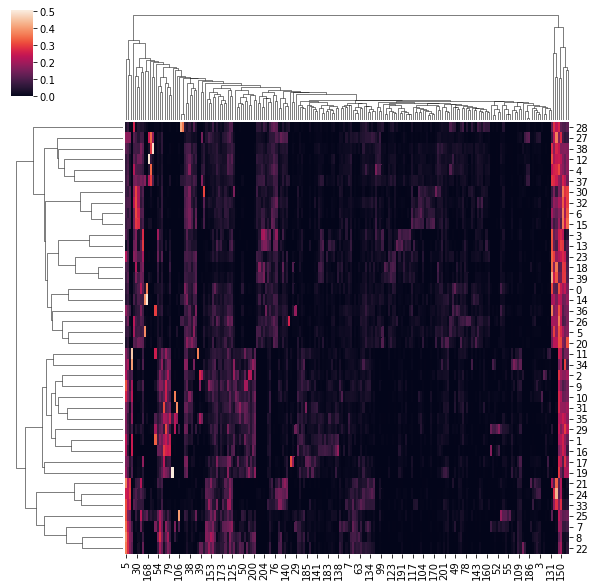

In [91]:
top_words = set()
for n in range(0,features.shape[0]-1):
    top_words.update(np.argsort(features[n,:])[-30:])
top_words = list(top_words)

# summary_df = pd.DataFrame(data=features[:,top_words],index=labels,)    # 1st column as index
#              columns=vocab_list[list(top_words)])  
    
# ax = sns.heatmap(summary_df)

ax = sns.clustermap(features[:,top_words])

In [96]:
this_index = 1
print(labels[this_index])

sorted_indexes = list(np.argsort(features[this_index,:]))
print(sorted_indexes[:30])
print(features[this_index,sorted_indexes[this_index]])
print(features[this_index,sorted_indexes[-1]])
print([vocab_list[idx] for idx in sorted_indexes[:100]])

Pinot Grigio
[499, 702, 703, 704, 705, 706, 326, 325, 323, 322, 708, 710, 711, 713, 714, 316, 717, 313, 721, 722, 310, 723, 308, 725, 727, 729, 332, 303, 334, 698]
0.0
0.33756951789570794
['weighty', 'toasted', 'linear', 'tangerine', 'result', 'lemony', 'beautifully', 'chocolaty', 'steak', 'bone', 'subdued', 'peaches', 'lemon-lime', 'grass', 'way', 'acidic', 'passion', 'cake', 'honeyed', 'chardonnay', 'graphite', 'value', 'syrup', 'taut', 'wrapped', 'drinking', 'leaf', 'easygoing', 'oregano', 'citrusy', 'expect', 'raisin', 'hills', 'gentle', 'brawny', 'attractive', 'skin', 'opens', 'persistent', 'leave', 'asian', 'bitter', 'golden', 'cuts', 'play', 'yellow', 'almond', 'sage', 'natural', 'real', 'char', 'barrel', 'friendly', 'pear', 'features', 'fig', 'direct', 'sleek', 'valley', 'mark', 'deeply', 'butterscotch', 'boasts', 'slight', 'blossoms', 'limes', 'minerals', 'nothing', 'across', 'bursting', 'loads', 'kiwi', 'packed', 'plush', 'moderately', 'seems', 'flower', 'loaded', 'flavored',

In [100]:
tfidf_dict['train']['Pinot Grigio'].count('cases')


0

In [103]:
wl.stop_words.set.update(['beautifully','subdued','way'])


True

In [ ]:
gensim.utils.lemmatize(wl.df.sample(n=1).description)

In [13]:
tfidf.vocabulary_

{'red': 5003,
 'cherry': 1060,
 'fruit': 2561,
 'comes': 1239,
 'laced': 3352,
 'light': 3482,
 'tannins': 6281,
 'giving': 2667,
 'bright': 744,
 'open': 4221,
 'juicy': 3287,
 'character': 1017,
 'dense': 1668,
 'packed': 4329,
 'acidity': 84,
 'brings': 765,
 'appellation': 274,
 'rich': 5180,
 'potential': 4669,
 'dark': 1571,
 'mineral': 3883,
 'texture': 6374,
 'concentrated': 1310,
 'cru': 1506,
 'one': 4210,
 'estates': 2093,
 'negociant': 4062,
 'house': 3003,
 'ripe': 5204,
 'fruity': 2569,
 'attractive': 369,
 'berry': 547,
 'finished': 2354,
 'crisp': 1493,
 'accessible': 66,
 'ready': 4976,
 'produced': 4769,
 'vines': 6841,
 'base': 466,
 'mount': 3970,
 'structure': 6061,
 'black': 579,
 'plum': 4600,
 'fruits': 2568,
 'generous': 2642,
 'balanced': 428,
 'solid': 5764,
 'wines': 7020,
 'firm': 2359,
 'balancing': 430,
 'still': 5989,
 'young': 7103,
 'fruitiness': 2566,
 'centered': 987,
 'around': 322,
 'core': 1413,
 'stylish': 6084,
 'warm': 6908,
 'round': 5275,
 'f

## How many wine varieties?

In [ ]:
varieties = list(wines['variety'])
varieties.remove(np.nan)
print("There is {} unique wine varieties in this list".format(len(set(varieties))))

In [766]:
wines.count()

country                  129908
description              129971
designation               92506
points                   129971
price                    120975
province                 129908
region_1                 108724
region_2                  50511
taster_name              103727
taster_twitter_handle     98758
title                    129971
variety                  129970
winery                   129971
dtype: int64

In [781]:
variety_cnt = {variety:len(wines[wines.variety==variety]) for variety in list(set(wines.variety))}
variety_cnt.pop(np.nan, None)

0

In [783]:

variety_cnt

{'Abouriou': 3,
 'Agiorgitiko': 63,
 'Aglianico': 359,
 'Aidani': 1,
 'Airen': 3,
 'Albana': 23,
 'Albanello': 1,
 'Albariño': 477,
 'Albarossa': 2,
 'Aleatico': 5,
 'Alfrocheiro': 16,
 'Alicante': 5,
 'Alicante Bouschet': 50,
 'Aligoté': 30,
 'Alsace white blend': 51,
 'Altesse': 8,
 'Alvarelhão': 2,
 'Alvarinho': 137,
 'Alvarinho-Chardonnay': 5,
 'Ansonica': 2,
 'Antão Vaz': 17,
 'Apple': 2,
 'Aragonez': 10,
 'Aragonês': 10,
 'Argaman': 3,
 'Arinto': 77,
 'Arneis': 86,
 'Asprinio': 3,
 'Assyrtico': 43,
 'Assyrtiko': 18,
 'Athiri': 1,
 'Austrian Red Blend': 62,
 'Austrian white blend': 80,
 'Auxerrois': 27,
 'Avesso': 6,
 'Azal': 3,
 'Babić': 4,
 'Babosa Negro': 1,
 'Bacchus': 2,
 'Baco Noir': 16,
 'Baga': 29,
 'Baga-Touriga Nacional': 2,
 'Barbera': 721,
 'Barbera-Nebbiolo': 1,
 'Bastardo': 2,
 'Biancale': 1,
 'Biancolella': 1,
 'Biancu Gentile': 1,
 'Bical': 13,
 'Black Monukka': 2,
 'Black Muscat': 11,
 'Blanc du Bois': 6,
 'Blatina': 1,
 'Blauburger': 1,
 'Blauburgunder': 1,
 'Bla

In [780]:
variety_cnt = {k:variety_cnt[k] for k in sorted(variety_cnt.copy(), key=variety_cnt.get, reverse=True)}
variety_cnt


{'Abouriou': 3,
 'Agiorgitiko': 63,
 'Aglianico': 359,
 'Aidani': 1,
 'Airen': 3,
 'Albana': 23,
 'Albanello': 1,
 'Albariño': 477,
 'Albarossa': 2,
 'Aleatico': 5,
 'Alfrocheiro': 16,
 'Alicante': 5,
 'Alicante Bouschet': 50,
 'Aligoté': 30,
 'Alsace white blend': 51,
 'Altesse': 8,
 'Alvarelhão': 2,
 'Alvarinho': 137,
 'Alvarinho-Chardonnay': 5,
 'Ansonica': 2,
 'Antão Vaz': 17,
 'Apple': 2,
 'Aragonez': 10,
 'Aragonês': 10,
 'Argaman': 3,
 'Arinto': 77,
 'Arneis': 86,
 'Asprinio': 3,
 'Assyrtico': 43,
 'Assyrtiko': 18,
 'Athiri': 1,
 'Austrian Red Blend': 62,
 'Austrian white blend': 80,
 'Auxerrois': 27,
 'Avesso': 6,
 'Azal': 3,
 'Babić': 4,
 'Babosa Negro': 1,
 'Bacchus': 2,
 'Baco Noir': 16,
 'Baga': 29,
 'Baga-Touriga Nacional': 2,
 'Barbera': 721,
 'Barbera-Nebbiolo': 1,
 'Bastardo': 2,
 'Biancale': 1,
 'Biancolella': 1,
 'Biancu Gentile': 1,
 'Bical': 13,
 'Black Monukka': 2,
 'Black Muscat': 11,
 'Blanc du Bois': 6,
 'Blatina': 1,
 'Blauburger': 1,
 'Blauburgunder': 1,
 'Bla

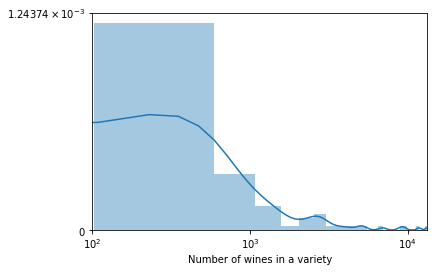

In [6]:
variety_cnt = Counter()
for variety in wines['variety']:
    variety_cnt[variety] += 1

variety_cnt
sorted_varieties = dict(sorted(variety_cnt.items(), key=lambda x: x[1]))
values = [x for x in variety_cnt.values()]
sns.distplot([value for value in values if value>100])#,hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True))
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlim([100, max(values)])
# plt.ylim([0.8, 1])
plt.xlabel('Fraction of varieties  of wines in a variety')
plt.xlabel('Number of wines in a variety')

129970

In [7]:
n_items_thresh = 500
vals_above_thresh = [value for value in values if value >n_items_thresh]

print("There are {} varieties of wines with more than {} entries in the DB. Total is {}".format(
    len(vals_above_thresh),
    n_items_thresh,
    sum(vals_above_thresh)
     ))

There are 40 varieties of wines with more than 500 entries in the DB. Total is 111797


In [8]:
top_varieties = {k:v for k,v in dict(variety_cnt).items() if v>n_items_thresh}
top_varieties

{'Barbera': 721,
 'Bordeaux-style Red Blend': 6915,
 'Bordeaux-style White Blend': 1066,
 'Cabernet Franc': 1353,
 'Cabernet Sauvignon': 9472,
 'Carmenère': 575,
 'Champagne Blend': 1396,
 'Chardonnay': 11753,
 'Chenin Blanc': 591,
 'Corvina, Rondinella, Molinara': 619,
 'Gamay': 1025,
 'Gewürztraminer': 1012,
 'Glera': 709,
 'Grenache': 651,
 'Grüner Veltliner': 1345,
 'Malbec': 2652,
 'Merlot': 3102,
 'Nebbiolo': 2804,
 'Petite Sirah': 770,
 'Pinot Grigio': 1052,
 'Pinot Gris': 1455,
 'Pinot Noir': 13272,
 'Port': 668,
 'Portuguese Red': 2466,
 'Portuguese White': 1159,
 'Red Blend': 8946,
 'Rhône-style Red Blend': 1471,
 'Riesling': 5189,
 'Rosé': 3564,
 'Sangiovese': 2707,
 'Sangiovese Grosso': 751,
 'Sauvignon Blanc': 4967,
 'Shiraz': 836,
 'Sparkling Blend': 2153,
 'Syrah': 4142,
 'Tempranillo': 1810,
 'Tempranillo Blend': 588,
 'Viognier': 996,
 'White Blend': 2360,
 'Zinfandel': 2714}

In [9]:
clean_tokenizer(wines.sample(n=1)['description'].values[0].lower())

['little',
 'sharp',
 'green',
 'give',
 'fatty',
 'steak',
 'ribs',
 'fine',
 'needs',
 'protein',
 'wake',
 'blackberry',
 'cherry',
 'sweetness']

In [10]:
corpus = dict.fromkeys(varieties,[])
for variety in top_varieties:
    print(variety)
    wines[wines['variety']==variety].apply(lambda x: corpus[variety].append(clean_tokenizer(x["description"])),axis = 1)

White Blend
Portuguese Red
Pinot Gris
Riesling
Pinot Noir
Gewürztraminer
Cabernet Sauvignon
Chardonnay
Malbec
Tempranillo Blend
Red Blend
Merlot
Chenin Blanc
Gamay
Sauvignon Blanc
Bordeaux-style White Blend
Sangiovese
Cabernet Franc
Champagne Blend
Bordeaux-style Red Blend
Petite Sirah
Carmenère
Rosé
Zinfandel
Grüner Veltliner
Viognier
Syrah
Nebbiolo
Barbera
Rhône-style Red Blend
Portuguese White
Sangiovese Grosso
Shiraz
Grenache
Sparkling Blend
Pinot Grigio
Tempranillo
Glera
Corvina, Rondinella, Molinara
Port


In [11]:
pooled_descs = []
[pooled_descs.extend(corpus[variety]) for variety in top_varieties]
print("'pooled_desc' contains {} descriptions from the top varieties".format(len(pooled_descs)))


'pooled_desc' contains 4471880 descriptions from the top varieties


In [12]:
vec_size = 80
model = gensim.models.Word2Vec(
        pooled_descs,
        size=vec_size,
        window=6,
        min_count=9,
        workers=8)
model.train(pooled_descs, total_examples=len(pooled_descs), epochs=10)
# full vocabulary
vocab = list(model.wv.vocab.keys())

In [16]:
word = 'gamay'#random.choice(wine_descriptors)
print(word)
model.wv.most_similar(word,topn=10)

gamay


/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('southwest', 0.5302480459213257),
 ('sancerre', 0.5065856575965881),
 ('castelão', 0.5005534887313843),
 ('aragonez', 0.4958513379096985),
 ('touraine', 0.49463576078414917),
 ('cahors', 0.49184635281562805),
 ('braucol', 0.4843861162662506),
 ('entre-deux-mers', 0.4777679443359375),
 ('volnay', 0.4765344262123108),
 ('chablis', 0.4668514132499695)]

In [40]:
wine_desc = wines.sample(n=1)['description'].values[0]
print(wine_desc)
# clean_desc = [x for x in clean_tokenizer(wine['description'].values[0]) if x in vocab]
print(get_sum_vec_from_desc(wine_desc,vocab))
model.most_similar(positive=[get_sum_vec_from_desc(wine_desc,vocab)])

This opens with toasted oak, pressed wild flower and hay aromas. The lean, diluted palate offers butterscotch and tart lemon zest flavors. Although the acidity is brisk, it lacks fruit richness.
[-2.94082165e-01 -5.60464973e+01 -1.45262825e+00 -1.73942108e+01
  1.22857437e+01  1.72421207e+01 -3.99139557e+01  2.71849689e+01
 -7.74311686e+00  8.35616016e+00 -1.00613441e+01 -8.89113712e+00
  8.29856396e+00 -1.63014851e+01 -1.59812584e+01 -2.73051243e+01
  2.99537029e+01 -2.57652397e+01 -1.13695965e+01 -5.53888702e+01
 -1.92564754e+01  1.68988628e+01  4.68231058e+00 -4.89358292e+01
 -2.69409904e+01  4.44895020e+01  2.08786430e+01 -8.28593063e+01
 -1.14602718e+01  5.40003052e+01  6.69587708e+01  1.70951443e+01
 -1.81608524e+01  1.92768822e+01 -1.65004206e+00 -1.93588066e+01
  6.61902332e+00  3.07023907e+01 -5.86293678e+01  1.63976021e+01
 -5.52686214e+00 -2.01167412e+01 -6.10869217e+00  4.42817116e+00
 -2.01548042e+01  1.82167702e+01 -5.20419931e+00 -2.99713993e+01
  1.61350765e+01  1.18772

/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('flower', 0.5820857286453247),
 ('hay', 0.5360601544380188),
 ('hazelnut', 0.5353198647499084),
 ('sensations', 0.5177141427993774),
 ('diluted', 0.515918493270874),
 ('subdued', 0.5122856497764587),
 ('palate', 0.5104039311408997),
 ('carry', 0.4997809827327728),
 ('camphor', 0.4944264590740204),
 ('wildflower', 0.4904298186302185)]

In [ ]:
def descriptions_similarity(desc1,desc2,**kwargs):
    vocab = kwargs.pop('vocab',None)
    if vocab:
        desc1 = list(set(desc1).intersection(vocab))
        desc2 = list(set(desc2).intersection(vocab))
    mean_vec1 = np.mean(model.wv[desc1],axis=0)
    mean_vec2 = np.mean(model.wv[desc2],axis=0)
    return cosine(mean_vec1, mean_vec2)

In [26]:
def get_mean_vec_from_desc(desc1,vocab):
    desc1 = list(set(clean_tokenizer(desc1)).intersection(vocab))
    return np.mean(model.wv[desc1],axis=0)

def get_sum_vec_from_desc(desc1,vocab):
    desc1 = list(set(clean_tokenizer(desc1)).intersection(vocab))
    return np.sum(model.wv[desc1],axis=0)

In [19]:
get_vec_from_desc(wines.sample(n=1)['description'].values[0],vocab)

array([ 7.4255908e-01, -6.7447525e-01,  4.3824881e-01, -1.5753216e+00,
        9.7110641e-01, -6.6371685e-01, -1.1124542e+00, -1.1458507e+00,
        4.3104401e-01, -8.4347337e-01,  4.1984591e-01, -1.6677872e-03,
        1.1446494e+00, -7.0013511e-01, -4.2652884e-01, -1.7681513e+00,
        1.0094731e+00,  9.6752447e-01,  8.5671866e-01, -1.2432399e+00,
       -2.1970728e-01,  1.2279481e+00, -2.4169913e-01,  3.9777160e-01,
       -6.4005840e-01, -7.2335768e-01,  3.4455556e-01, -1.5039772e+00,
       -1.0220701e+00,  1.2937248e+00,  2.3823302e+00,  2.1789715e-01,
       -7.9702055e-01, -6.1601764e-01, -3.3324748e-01,  8.8962816e-02,
        1.7455890e+00,  3.4582523e-01, -3.5015002e-01,  3.4640771e-01,
       -7.2422349e-01,  1.8049160e+00, -1.4210504e-01,  3.9166111e-01,
       -3.3659661e-01,  7.3540084e-02, -7.4349827e-01, -4.3122867e-01,
        1.7135633e+00, -1.7055099e-01,  6.0302973e-01,  1.5474998e+00,
       -2.5902635e-01, -1.5172492e+00, -4.2691761e-01,  1.1775168e+00,
      

In [130]:
def get_mean_variety_vec(corpus,variety,vocab):
    if variety in list(corpus.keys()):
        pooled_desc = itertools.chain.from_iterable(corpus[variety])
        return np.mean(model.wv[pooled_desc],axis=0)
    else:
        raise ValueError("unknown variety")
            

In [49]:
variety = "Glera"  #"Port

wine_1 = wines[wines['variety']==variety].sample(n=1)
wine_1


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
122157,Italy,Simple tones of white fruit and crushed stone ...,Brut,86,18.0,Veneto,Asolo Prosecco Superiore,NaN,NaN,NaN,Case Paolin NV Brut (Asolo Prosecco Superiore),Glera,Case Paolin


In [51]:
wine_2 = wines[wines['variety']==variety].sample(n=1)
wine_2

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
61669,Italy,Aromas of jasmine and white orchard fruit lead...,Brut,87,17.0,Veneto,Conegliano Valdobbiadene Prosecco Superiore,NaN,Kerin O’Keefe,@kerinokeefe,Raphael Dal Bo NV Brut (Conegliano Valdobbiad...,Glera,Raphael Dal Bo


In [85]:
vec_1 = get_sum_vec_from_desc(wine_1['description'].values[0],vocab)
vec_1
model.similar_by_vector(vec_1)

NameError: name 'get_sum_vec_from_desc' is not defined

In [49]:
for idx, wine in wines.sample(n=10).iterrows():
    print(wine['title'],"-/--",wine['variety'])

Robert Weil 2011 Kiedrich Gräfenberg Erstes Gewächs Trocken Riesling (Rheingau) -/-- Riesling
Domaine Gavoty 2014 Cuvée Tradition Rosé (Côtes de Provence) -/-- Rosé
Adriano Marco & Vittorio 2011  Moscato d'Asti -/-- Moscato
Rosemont 2011 Syrah (Virginia) -/-- Syrah
Aveleda NV Casal Garcia Medium Dry Sparkling (Vinho Verde) -/-- Portuguese Sparkling
Château la Marzelle 2014  Saint-Émilion -/-- Bordeaux-style Red Blend
Three Rivers 2013 Malbec-Merlot (Columbia Valley (WA)) -/-- Malbec-Merlot
Hamlet 2012 Pinot Gris (Virginia) -/-- Pinot Gris
Gérard Bertrand 2014 Château La Sauvageonne GMVV Rosé (Coteaux du Languedoc) -/-- Rosé
Testarossa 2009 Garys' Vineyard Syrah (Santa Lucia Highlands) -/-- Syrah


In [ ]:
variety_feat_mat = np.empty([vec_size, len(top_varieties)])
for idx, variety in enumerate(top_varieties):
    variety_feat_mat[:,idx] = get_mean_variety_vec(corpus,variety,vocab)
#     print(mean_variety_vec.shape)
#     variety_feat_mat = np.concatenate((variety_feat_mat, mean_variety_vec), axis=1)

In [20]:
model.wv['acid']

array([ 0.7251488 , -2.5317702 , -1.9163985 ,  4.0889997 ,  3.8206613 ,
       -1.4792136 , -5.589569  , -3.8782206 , -1.7768035 ,  2.5695996 ,
        0.72781545,  2.0208828 , -1.671599  , -4.135302  ,  0.95505404,
       -5.904454  ,  1.3468721 , -1.5988615 ,  6.5539546 ,  0.01805219,
       -1.4194012 ,  1.926158  ,  2.7366133 , -1.7378643 ,  2.5590408 ,
        1.8827958 ,  3.3593783 , -3.102206  , -1.734364  ,  1.7118086 ,
        0.7918724 , -0.60808367,  3.2343788 ,  3.4260652 ,  1.6703877 ,
       -0.821487  ,  4.73939   , -0.36875728,  3.4355805 , -1.299591  ,
       -5.047547  ,  0.08424437,  0.42921612, -2.2511663 , -5.626322  ,
       -0.57558525,  6.667234  , -4.0419173 ,  2.5485682 , -0.8304031 ,
       -3.8161948 ,  2.3767161 ,  1.569417  , -1.6394805 ,  6.7740526 ,
        4.0599084 ,  5.3935957 , -3.0815043 ,  2.7535233 , -2.2571151 ,
       -4.596458  , -1.1683162 , -6.1627836 , -0.30625075,  1.820235  ,
       -5.5278277 , -2.441061  , -6.6247087 , -1.5127312 ,  0.60

In [22]:
wines.sample(n=1)['description'].values[0]

'Minty oaky aromas of baking spices share space on the nose with earthy black plum and berry notes. This feels tannic and resiny while the oaky spicy berry flavors finish with force and drying tannins.'

In [74]:
# pick random wine
this_wine = wines.sample(n=1)
prin(this_wine['variety'].values[0])




array(['Pinot Noir'], dtype=object)

In [75]:
variety_feat_mat.shape

(80, 128)

In [76]:
feat_vect = get_vec_from_desc(wines.sample(n=1)['description'].values[0],vocab)
feat_vect.shape

(80,)

In [82]:
cosines_to_varieties = [cosine(feat_vect,x) for x in ]/np.linalg.norm(feat_vect)

cosine_closest = np.array([(feat_vect,variety_feat_mat[:,0])/np.linalg.norm(feat_vect) for feat_vect in ])

In [125]:
cosine_to_varieties = np.empty([len(top_varieties),1])
for index in range(0,variety_feat_mat.shape[1]-1):
    x =  variety_feat_mat[:,index]
    cosine_to_varieties[index] = cosine(x,feat_vect)#/np.linalg.norm(feat_vect)


In [126]:
cosine_to_varieties

array([[1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.54837832],
       [1.548

In [127]:
variety_feat_mat[:,0]

array([ 0.11044145, -0.07531391,  0.07324275, -0.01208648,  0.29134712,
       -0.00666942,  0.09475937, -0.25099552,  0.27502015,  0.05638684,
       -0.04598946,  0.20567501,  0.19647652,  0.03817679, -0.00665   ,
        0.1599315 , -0.07453687, -0.30949321,  0.04190506, -0.21889822,
        0.21222253, -0.27521598,  0.18922079,  0.5024814 ,  0.19261868,
        0.15738899,  0.06505712,  0.34035936,  0.05964699,  0.0788378 ,
        0.19690418,  0.07246489, -0.07701673,  0.45772335, -0.03854014,
        0.16730706, -0.09149095,  0.04378865, -0.09555584, -0.23299222,
       -0.00956781, -0.19048984,  0.2147489 ,  0.06496047,  0.07217062,
       -0.17329443,  0.0206799 ,  0.17356676, -0.19051684,  0.22575979,
       -0.06652635, -0.2836675 , -0.1738915 , -0.49212253,  0.13728528,
        0.25923604, -0.0082758 ,  0.00224301, -0.0121464 , -0.38505086,
        0.06126573, -0.45131955, -0.23558451, -0.28431478, -0.04035823,
        0.550915  , -0.03473023,  0.36679521, -0.12635785, -0.27

In [128]:
variety_feat_mat[:,1]

array([ 0.11044145, -0.07531391,  0.07324275, -0.01208648,  0.29134712,
       -0.00666942,  0.09475937, -0.25099552,  0.27502015,  0.05638684,
       -0.04598946,  0.20567501,  0.19647652,  0.03817679, -0.00665   ,
        0.1599315 , -0.07453687, -0.30949321,  0.04190506, -0.21889822,
        0.21222253, -0.27521598,  0.18922079,  0.5024814 ,  0.19261868,
        0.15738899,  0.06505712,  0.34035936,  0.05964699,  0.0788378 ,
        0.19690418,  0.07246489, -0.07701673,  0.45772335, -0.03854014,
        0.16730706, -0.09149095,  0.04378865, -0.09555584, -0.23299222,
       -0.00956781, -0.19048984,  0.2147489 ,  0.06496047,  0.07217062,
       -0.17329443,  0.0206799 ,  0.17356676, -0.19051684,  0.22575979,
       -0.06652635, -0.2836675 , -0.1738915 , -0.49212253,  0.13728528,
        0.25923604, -0.0082758 ,  0.00224301, -0.0121464 , -0.38505086,
        0.06126573, -0.45131955, -0.23558451, -0.28431478, -0.04035823,
        0.550915  , -0.03473023,  0.36679521, -0.12635785, -0.27

In [134]:
desc = wines.sample(n=1)['description'].values[0]
feat_vect = get_vec_from_desc(desc,vocab)
feat_vect

array([-0.7182256 ,  0.06999971,  0.40370917,  1.670079  ,  0.39207706,
       -0.85007536, -0.3161564 ,  1.4158924 ,  0.01899183, -0.1163108 ,
       -0.05102564, -0.5171817 , -0.17992505, -1.1451402 ,  0.03381827,
       -0.77340025,  1.3569076 ,  0.4627354 ,  0.25461695,  0.55995184,
       -0.20673874, -0.10636199,  0.6026641 , -0.50085175,  0.6206533 ,
       -0.4025708 ,  0.08637564, -1.2782971 , -0.8569147 ,  0.99577606,
       -0.88288003,  0.45781356, -0.20737067, -0.8445204 ,  0.75970316,
       -0.3116216 , -0.13305654, -0.9566633 ,  0.9335165 ,  0.794845  ,
       -0.8124663 ,  0.5459155 ,  0.1472731 , -0.42321014, -0.94805497,
        1.0300369 ,  0.22011289,  0.23022513,  0.22038841, -0.3637021 ,
        0.2154892 ,  0.8335578 , -0.60324615, -0.13780074, -1.0483205 ,
        0.5606314 ,  0.08425167,  0.01305277,  0.20231557,  1.6649086 ,
       -1.0700958 , -0.672184  ,  1.0395004 ,  0.8756982 ,  0.7647904 ,
       -0.6989334 ,  0.15982085, -0.7502614 ,  0.91621435,  0.70

In [138]:
feat_vect = get_vec_from_desc(desc,vocab)
feat_vect

array([-0.7182256 ,  0.06999971,  0.40370917,  1.670079  ,  0.39207706,
       -0.85007536, -0.3161564 ,  1.4158924 ,  0.01899183, -0.1163108 ,
       -0.05102564, -0.5171817 , -0.17992505, -1.1451402 ,  0.03381827,
       -0.77340025,  1.3569076 ,  0.4627354 ,  0.25461695,  0.55995184,
       -0.20673874, -0.10636199,  0.6026641 , -0.50085175,  0.6206533 ,
       -0.4025708 ,  0.08637564, -1.2782971 , -0.8569147 ,  0.99577606,
       -0.88288003,  0.45781356, -0.20737067, -0.8445204 ,  0.75970316,
       -0.3116216 , -0.13305654, -0.9566633 ,  0.9335165 ,  0.794845  ,
       -0.8124663 ,  0.5459155 ,  0.1472731 , -0.42321014, -0.94805497,
        1.0300369 ,  0.22011289,  0.23022513,  0.22038841, -0.3637021 ,
        0.2154892 ,  0.8335578 , -0.60324615, -0.13780074, -1.0483205 ,
        0.5606314 ,  0.08425167,  0.01305277,  0.20231557,  1.6649086 ,
       -1.0700958 , -0.672184  ,  1.0395004 ,  0.8756982 ,  0.7647904 ,
       -0.6989334 ,  0.15982085, -0.7502614 ,  0.91621435,  0.70

In [156]:
token_list = clean_tokenizer(desc)
random.shuffle(token_list)
feat_vect = get_vec_from_desc(" ".join(token_list),vocab)
feat_vect

array([-0.7182256 ,  0.06999971,  0.40370917,  1.670079  ,  0.39207706,
       -0.85007536, -0.3161564 ,  1.4158924 ,  0.01899183, -0.1163108 ,
       -0.05102564, -0.5171817 , -0.17992505, -1.1451402 ,  0.03381827,
       -0.77340025,  1.3569076 ,  0.4627354 ,  0.25461695,  0.55995184,
       -0.20673874, -0.10636199,  0.6026641 , -0.50085175,  0.6206533 ,
       -0.4025708 ,  0.08637564, -1.2782971 , -0.8569147 ,  0.99577606,
       -0.88288003,  0.45781356, -0.20737067, -0.8445204 ,  0.75970316,
       -0.3116216 , -0.13305654, -0.9566633 ,  0.9335165 ,  0.794845  ,
       -0.8124663 ,  0.5459155 ,  0.1472731 , -0.42321014, -0.94805497,
        1.0300369 ,  0.22011289,  0.23022513,  0.22038841, -0.3637021 ,
        0.2154892 ,  0.8335578 , -0.60324615, -0.13780074, -1.0483205 ,
        0.5606314 ,  0.08425167,  0.01305277,  0.20231557,  1.6649086 ,
       -1.0700958 , -0.672184  ,  1.0395004 ,  0.8756982 ,  0.7647904 ,
       -0.6989334 ,  0.15982085, -0.7502614 ,  0.91621435,  0.70

In [98]:
y_true = [str(x) for x in [2, 0, 2, 2, 0, 1]]
y_pred = [str(x) for x in [0, 0, 2, 2, 0, 2]]
y_pred


array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

In [148]:
random.shuffle([1,3,45,45,45,4,5random.sample(x, len(x))

In [160]:
variety_feat_mat[0]

array([0.00000000e+000, 1.25767710e-076, 0.00000000e+000, 3.85464794e-057,
       1.25767909e-076, 8.97917664e-067, 1.83153583e-076, 1.25771476e-076,
       6.00893663e-067, 1.51898041e-047, 1.25767446e-076, 6.82016317e-038,
       5.63863945e-062, 6.96324176e-077, 8.98354613e-067, 5.34618094e-038,
       1.81149296e-152, 1.42759683e-071, 8.54289848e-072, 1.58116940e-153,
       5.94082931e-038, 1.30355142e-076, 1.65662909e-153, 4.85260286e-033,
       1.30355142e-076, 1.39638544e+136, 8.97190379e-067, 6.96323520e-077,
       1.83255844e-076, 3.24263858e-086, 2.10816434e-052, 5.15722155e-062,
       3.24245682e-086, 2.42178677e-052, 1.57110400e-076, 3.24245691e-086,
       6.38563587e-067, 1.51818066e-047, 6.12743499e-154, 4.08598376e-033,
       1.89812469e-052, 6.03981071e-154, 1.57077328e-076, 1.68931486e-052,
       2.48583955e-091, 4.66527025e-033, 1.57009187e-076, 4.07628811e+223,
       3.54039294e-057, 3.24245684e-086, 4.47042615e-033, 1.51818066e-047,
       3.24245662e-086, 1

In [25]:
[x for x in clean_tokenizer(wines.sample(n=1)['description'].values[0]) if x in vocab]

['nice',
 'little',
 'red',
 'blend',
 'easy',
 'drink',
 'cheerful',
 'flavors',
 'blackberries',
 'cherries',
 'ripe',
 'without',
 'face',
 'entirely',
 'dry',
 'light',
 'tannins',
 'enjoy',
 'everything',
 'sandwiches',
 'steak']

['White Blend',
 'Portuguese Red',
 'Pinot Gris',
 'Riesling',
 'Pinot Noir',
 'Tempranillo-Merlot',
 'Frappato',
 'Gewürztraminer',
 'Gewürztraminer',
 'Pinot Gris',
 'Cabernet Sauvignon',
 'Gewürztraminer',
 'Cabernet Sauvignon',
 'Nerello Mascalese',
 'Chardonnay',
 'Riesling',
 'Malbec',
 'Malbec',
 'Tempranillo Blend',
 'Meritage',
 'Red Blend',
 'Pinot Noir',
 'White Blend',
 'Merlot',
 "Nero d'Avola",
 'Pinot Noir',
 'White Blend',
 "Nero d'Avola",
 'Red Blend',
 'Chenin Blanc',
 'Gamay',
 'Red Blend',
 'White Blend',
 'Red Blend',
 'Sauvignon Blanc',
 'Pinot Noir',
 'Viognier-Chardonnay',
 'Cabernet Sauvignon',
 'Primitivo',
 "Nero d'Avola",
 'Catarratto',
 'Pinot Noir',
 'Gamay',
 'Sauvignon Blanc',
 'Merlot',
 'Red Blend',
 'Inzolia',
 'Riesling',
 'Sauvignon Blanc',
 'Gamay',
 'Red Blend',
 'Petit Verdot',
 'Monica',
 'Bordeaux-style White Blend',
 'Red Blend',
 'Chardonnay',
 'Chardonnay',
 'Grillo',
 'Pinot Noir',
 'Malbec',
 'Cabernet Sauvignon',
 'Sangiovese',
 'Cabernet

In [44]:
model.most_similar(positive=['chardonnay'])

/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('chard', 0.8095741271972656),
 ('blanc', 0.6153700351715088),
 ('chardonnays', 0.6071824431419373),
 ('gewürz', 0.5741649270057678),
 ('riesling', 0.530490517616272),
 ('chards', 0.5127464532852173),
 ('viognier', 0.5119463801383972),
 ('bubbly', 0.5010278224945068),
 ('sémillon', 0.49409496784210205),
 ('champagne', 0.4821004867553711)]

# Doc2Vec Attempt


In [7]:
#Import all the dependencies
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [320]:
# data = ["I love machine learning. Its awesome.",
#         "I love building chatbots",        
#         "I love coding in python",
#         "they chat amagingly well"]

sub_df = wines.sample(n=50000)
# [clean_tokenizer(item['description']) for (_,item) in sub_df.iterrows()]

In [321]:
tagged_data = [TaggedDocument(words=clean_tokenizer(_item['description']), tags=[idx]) for idx, _item in sub_df.iterrows()]
# for idx, wine in sub_df.iterrows():
# sub_df[sub_df.index==65861]

In [195]:
# tagged_data

[TaggedDocument(words=['harrison', 'hill', 'vineyard', 'washington', 'oldest', 'cabernet', 'vines', 'blend', 'cabernet', 'sauvignon', 'merlot', 'cabernet', 'franc', 'petit', 'verdot', 'offers', 'distinctive', 'flavor', 'profile', 'clean', 'sharp', 'herbal', 'interesting', 'earthy', 'note', 'flavors', 'mingle', 'beautifully', 'carry', 'tart', 'tight-knit', 'red', 'fruit', 'polished', 'lightly', 'slatey', 'tannins', 'chewy', 'lightly', 'peppery', 'finish'], tags=[65861]),
 TaggedDocument(words=['blend', 'premier', 'grand', 'cru', 'pinot', 'noir', 'chardonnay', 'vintages', 'difficult', 'harvest', 'rare', 'wine', 'soft', 'texture', 'smooth', 'fruit', 'exception', 'already', 'mature', 'offers', 'hints', 'almonds', 'well', 'ripe', 'fruits', 'ready', 'drink', 'rich', 'middle', 'crisp', 'end'], tags=[84337]),
 TaggedDocument(words=['ripe', 'berries', 'violets', 'scent', 'heady', 'perfumed', 'riesling', 'palate', 'rich', 'confectionery', 'style', 'candied', 'cherry', 'honey', 'notes', 'linger',

In [350]:
max_epochs = 20
vec_size = 40
alpha = 0.025

# model = Doc2Vec(size=vec_size,
#                 alpha=alpha, 
#                 min_alpha=0.00025,
#                 min_count=10,
#                 dm =1)

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=10,
                dm =0)

  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    clear_output(wait=True)
    display('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha


'iteration 19'

In [399]:
keepgoing = True
while keepgoing:
    this_wine = wines.sample(n=1)
    if not this_wine.index in list(sub_df.index):
        keepgoing = False
    

In [400]:
new_desc = clean_tokenizer(this_wine['description'].values[0],vocab=list(model.wv.vocab.keys()))
print(new_desc)
v1 = model.infer_vector(new_desc)#,epochs=10)
print("V1_infer", v1)

['bold', 'floral', 'aromas', 'rubbery', 'red-berry', 'fruits', 'introduce', 'full', 'fresh', 'largely', 'elegant', 'palate', 'home', 'minerally', 'medicinal', 'cherry', 'plum', 'berry', 'flavors', 'wood', 'grain', 'resiny', 'notes', 'apparent', 'finish', 'long', 'driving', 'spicy', 'oaky']
V1_infer [ 0.24842426 -0.4385322  -0.6695642  -0.1958748   0.19899486  0.74873865
 -0.43309125  0.08314032 -0.07824121 -0.32565644  0.79224205  0.15797025
  0.04483354  0.73007745  0.84476453  0.24153346 -0.4891824   0.29038113
 -0.24302994  0.72109085  0.4217465   0.69456285 -0.36800075 -0.15925303
 -0.01483875 -0.35381356  0.409442    0.27522963  0.16810103  0.79118264
  0.19807798  0.07103125  0.5354564  -0.42346767  0.01216246  0.5215756
 -0.77194214  0.15399766  0.77446336 -0.46443617]


In [401]:
# to find most similar doc using tags
similar_doc = model.docvecs.most_similar([v1])
print(similar_doc)
similar_doc[0][0]

# # to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
# print(model.docvecs['1'])

[(106082, 0.6994798183441162), (56830, 0.694687008857727), (101226, 0.6798180937767029), (11430, 0.6589768528938293), (23518, 0.6373549103736877), (120383, 0.6366267800331116), (116108, 0.6212053298950195), (97389, 0.6190168261528015), (53536, 0.6188226938247681), (17081, 0.6064379811286926)]


/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


106082

In [402]:
clean_tokenizer(wines.loc[similar_doc[0][0]]['description'],vocab=vocab)

['briary',
 'red-berry',
 'plum',
 'aromas',
 'earthy',
 'rubbery',
 'medium',
 'body',
 'bit',
 'heavy',
 'just-adequate',
 'acidity',
 'solid',
 'flavors',
 'plum',
 'berry',
 'resiny',
 'oak',
 'finish',
 'oaky',
 'medicinal',
 'tasting']

In [403]:
clean_tokenizer(this_wine['description'].values[0],vocab=vocab)

['bold',
 'floral',
 'aromas',
 'rubbery',
 'red-berry',
 'fruits',
 'introduce',
 'full',
 'fresh',
 'largely',
 'elegant',
 'palate',
 'home',
 'minerally',
 'medicinal',
 'cherry',
 'plum',
 'berry',
 'flavors',
 'wood',
 'grain',
 'resiny',
 'notes',
 'apparent',
 'finish',
 'long',
 'driving',
 'spicy',
 'oaky']

In [404]:
print(wines.loc[similar_doc[0][0]]['description'],wines.loc[similar_doc[0][0]]['variety'])

The briary red-berry and plum aromas are earthy and rubbery. This is medium in body and a bit heavy, with just-adequate acidity and solid flavors of plum, berry and resiny oak. The finish is oaky and medicinal tasting. Merlot


In [405]:
print(this_wine['description'].values[0],this_wine['variety'])

Bold, floral aromas of rubbery red-berry fruits introduce a full, fresh, largely elegant palate that's home to minerally, medicinal cherry, plum and berry flavors. Wood grain and resiny notes are apparent on the finish, which is long, driving, spicy and oaky. 110706    Mencía
Name: variety, dtype: object


In [406]:
this_wine

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
110706,Spain,"Bold, floral aromas of rubbery red-berry fruit...",Pétalos,90,22.0,Northern Spain,Bierzo,NaN,Michael Schachner,@wineschach,Descendientes de J. Palacios 2012 Pétalos Menc...,Mencía,Descendientes de J. Palacios


In [ ]:
article_mat = np.ndarray(shape=[np.shape(article_string)[0],vec_size])
for idx in range(0,len(article_string)):
    a = article_string[idx]
    a = [r for r in article_string[idx] if r in model.wv.vocab]
    array_for_art = np.ndarray(shape=[len(a),vec_size])
    for i in range(0,len(a)):
        array_for_art[i,:] = model.wv.get_vector(a[i])
    article_mat[idx,:] = np.mean(array_for_art, axis=0)

In [ ]:
for idx, _some_wine in wines[wines['variety']=='Bordeaux-style Red Blend'].sample(n=30).iterrows():
    print("{}   /   {}".format(_some_wine['variety'],_some_wine['title']))
    print(_some_wine['description'])
    print("--------------------------------------------------------")
    print("")
    print("")
    

In [456]:
top_varieties

{'Barbera': 721,
 'Bordeaux-style Red Blend': 6915,
 'Bordeaux-style White Blend': 1066,
 'Cabernet Franc': 1353,
 'Cabernet Sauvignon': 9472,
 'Carmenère': 575,
 'Champagne Blend': 1396,
 'Chardonnay': 11753,
 'Chenin Blanc': 591,
 'Corvina, Rondinella, Molinara': 619,
 'Gamay': 1025,
 'Gewürztraminer': 1012,
 'Glera': 709,
 'Grenache': 651,
 'Grüner Veltliner': 1345,
 'Malbec': 2652,
 'Merlot': 3102,
 'Nebbiolo': 2804,
 'Petite Sirah': 770,
 'Pinot Grigio': 1052,
 'Pinot Gris': 1455,
 'Pinot Noir': 13272,
 'Port': 668,
 'Portuguese Red': 2466,
 'Portuguese White': 1159,
 'Red Blend': 8946,
 'Rhône-style Red Blend': 1471,
 'Riesling': 5189,
 'Rosé': 3564,
 'Sangiovese': 2707,
 'Sangiovese Grosso': 751,
 'Sauvignon Blanc': 4967,
 'Shiraz': 836,
 'Sparkling Blend': 2153,
 'Syrah': 4142,
 'Tempranillo': 1810,
 'Tempranillo Blend': 588,
 'Viognier': 996,
 'White Blend': 2360,
 'Zinfandel': 2714}

In [540]:
variety = random.choice(list(top_varieties.keys()))
wine = wines[wines['variety']==variety].sample(n=1)
print(wine['description'].values[0].replace(variety,"XXXXXX"))

One of the most attractive aspects of this fresh white blend is its structure: The wine is silky and smooth and seemingly weightless at the same time. That kind of structure is a good platform for flavors of pear, exotic fruit, honey and almond. Try it with grilled shrimp in a cilantro pesto sauce.


In [480]:
print(wine['title'].values[0])
print(wine['variety'].values[0])


Ehrhardt 2005 Chenin Blanc (Clarksburg)
Chenin Blanc


In [465]:
tfidf = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x : x,
        preprocessor=lambda x : x,
        token_pattern=None)
        tfidf.fit(list(self.get_docs().values()))

0

In [564]:
counters = dict()
full_counter = Counter()
for variety in list(top_varieties.keys())[0:4]:
    if not 'blend' in variety.lower():
        clear_output(wait=True)
        display(variety)
        pooled_words = []
        [pooled_words.extend(clean_tokenizer(item['description'],extra_stop=wine_stop)) for idx, item in wines[wines['variety']==variety].iterrows()]
        counters[variety] = Counter(pooled_words)
        full_counter+=counters[variety]
        

'Riesling'

In [567]:
norm_counters = dict.fromkeys(counters.keys(),dict())
for variety in counters.keys():
    for key in 
    norm_counters[variety]

Counter({'tart': 107,
         'snappy': 11,
         'lime': 82,
         'flesh': 30,
         'rind': 36,
         'dominate': 10,
         'green': 114,
         'pineapple': 86,
         'pokes': 1,
         'crisp': 183,
         'acidity': 368,
         'underscoring': 2,
         'stainless-steel': 6,
         'fermented': 63,
         'great': 59,
         'depth': 34,
         'flavor': 101,
         'fresh': 333,
         'apple': 401,
         'pear': 721,
         'fruits': 91,
         'touch': 135,
         'spice': 178,
         'dry': 332,
         'balanced': 129,
         'texture': 159,
         'perceptible': 3,
         'sweetness': 118,
         'tropical': 82,
         'nose': 234,
         'yet': 42,
         'tastes': 23,
         'showing': 40,
         'straightforward': 15,
         'approach': 4,
         'coastal-grown': 1,
         'variety': 23,
         'apricot': 76,
         'melon': 173,
         'guava': 13,
         'wrap': 4,
         'around': 2

In [486]:
# wine_stop = set()

In [548]:
# manually building stop words
this_wine = wines.sample(n=1)
wine_tokens = clean_tokenizer(this_wine['description'].values[0],extra_stop=wine_stop)
print(wine_tokens)

['solid', 'mainstream', 'zinfandel', 'displays', 'blackberry', 'fruit', 'creamy', 'notes', 'nose', 'well-defined', 'dark', 'berry', 'white', 'pepper', 'leather', 'accents', 'mark', 'palate', 'mouthfeel', 'finish', 'brisk', 'tart', 'juicy', 'touch', 'less', 'oak', 'might', 'let', 'fruit', 'shine', 'bit']


In [575]:
wine_stop.update(['alongside'])

In [544]:
print(this_wine['description'].values[0])
print(this_wine['points'].values[0])

Basic and a little sweet and confected, but consider the price and you should be smiling. There's some bramble and pepper to the nose, but mostly it's just ripe and full of blackberry and black plum character. Candied and almost cloying, but remains flush and happy. Good in the midlevel category.
86


In [518]:
"remove all years and punctuation"
'sb-like'
'Drink 2023–2033.'
'now–2014'
'Try it with grilled shrimp in a cilantro pesto sauce.'

'remove all years and punctuation'

In [530]:
this_wine

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2773,Chile,"Prickly, punchy, pryazinic aromas will have yo...",Estate Bottled,83,12.0,Casablanca Valley,NaN,NaN,Michael Schachner,@wineschach,Albamar 2015 Estate Bottled Chardonnay (Casabl...,Chardonnay,Albamar


In [551]:
top_varieties

{'Barbera': 721,
 'Bordeaux-style Red Blend': 6915,
 'Bordeaux-style White Blend': 1066,
 'Cabernet Franc': 1353,
 'Cabernet Sauvignon': 9472,
 'Carmenère': 575,
 'Champagne Blend': 1396,
 'Chardonnay': 11753,
 'Chenin Blanc': 591,
 'Corvina, Rondinella, Molinara': 619,
 'Gamay': 1025,
 'Gewürztraminer': 1012,
 'Glera': 709,
 'Grenache': 651,
 'Grüner Veltliner': 1345,
 'Malbec': 2652,
 'Merlot': 3102,
 'Nebbiolo': 2804,
 'Petite Sirah': 770,
 'Pinot Grigio': 1052,
 'Pinot Gris': 1455,
 'Pinot Noir': 13272,
 'Port': 668,
 'Portuguese Red': 2466,
 'Portuguese White': 1159,
 'Red Blend': 8946,
 'Rhône-style Red Blend': 1471,
 'Riesling': 5189,
 'Rosé': 3564,
 'Sangiovese': 2707,
 'Sangiovese Grosso': 751,
 'Sauvignon Blanc': 4967,
 'Shiraz': 836,
 'Sparkling Blend': 2153,
 'Syrah': 4142,
 'Tempranillo': 1810,
 'Tempranillo Blend': 588,
 'Viognier': 996,
 'White Blend': 2360,
 'Zinfandel': 2714}

In [705]:
reload(wcu)
wine_stop = wcu.StopWords('wine',file_path='wine.stop_words')

In [763]:
# split the data frame
msk = np.random.rand(len(wines)) < 0.66

train_wines = wines[msk]

test_wines = wines[~msk]


tfidf = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm='l2',
    encoding='latin-1',
#     ngram_range=(1),# 2),
    stop_words=stopwords.words('english') + list(string.punctuation) +["'s"]+years+list(wine_stop.set))

features = tfidf.fit_transform(
        [train_wines[train_wines.variety==variety].description.str.cat() for variety in top_varieties]
    ).toarray()
labels = list(top_varieties.keys())
features.shape

/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(40, 7440)

In [720]:
tfidf.transform(['offering'])

/Users/jonathansaragosti/miniconda3/envs/insight/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<1x12168 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [732]:
features[0]

array([0.00580786, 0.        , 0.        , ..., 0.        , 0.02079956,
       0.        ])

In [716]:
wine_stop.set.update(['bit'])
wine_stop.save()
print(wine_stop.set)

{'drinkable', 'slightly', 'drink', 'better', 'dishes', 'bit', 'dr.', 'gives', 'perhaps', 'plenty', 'fine', 'alongside', 'another', 'zebra', 'offers', 'smiling', 'maybe', 'highly', 'style', 'add', 'year', 'mouth', 'consider', 'enhanced', 'good', 'plus', '100', 'case', 'possibility', 'include', 'category', 'flavors', 'elements', 'already', 'although', 'fairly', 'blend', 'price', 'well', 'quite', 'thai', 'indian', 'midlevel', 'wine', 'followed', 'even', 'key'}


In [685]:
wine_stop = wcu.StopWords('wine',file_path='wine.stop_words')
wine_stop.set


{'100',
 'add',
 'alongside',
 'already',
 'although',
 'another',
 'better',
 'blend',
 'category',
 'certainly',
 'consider',
 'dishes',
 'dr.',
 'drink',
 'drinkable',
 'elements',
 'enhanced',
 'even',
 'fine',
 'flavors',
 'followed',
 'gives',
 'good',
 'highly',
 'indian',
 'key',
 'maybe',
 'midlevel',
 'mouth',
 'offers',
 'perhaps',
 'plenty',
 'plus',
 'possibility',
 'price',
 'quite',
 'slightly',
 'smiling',
 'style',
 'thai',
 'well',
 'wine',
 'year'}

In [615]:
import pickle

with open('wine.stop_words', 'wb') as fp:
    pickle.dump(wine_stop, fp)

In [592]:
with open ('wine.stop_words', 'rb') as fp:
    test = pickle.load(fp)

In [594]:
from wine_and_cheese_utils import StopWords


In [614]:
with open ('wine.stop_words', 'rb') as fp:
    yo = pickle.load(fp)

EOFError: Ran out of input

In [675]:
wine_stop2.set = wine_stop2.set.difference(['a','l','o','olala'])

In [677]:
wine_stop2.save()

In [662]:
wine_stop2.update_and_save(['olala'])


In [679]:
wine_stop2.set

{'100',
 'add',
 'alongside',
 'although',
 'another',
 'blend',
 'category',
 'consider',
 'dishes',
 'dr.',
 'drink',
 'drinkable',
 'elements',
 'enhanced',
 'even',
 'fine',
 'flavors',
 'followed',
 'gives',
 'good',
 'highly',
 'indian',
 'key',
 'maybe',
 'midlevel',
 'mouth',
 'offers',
 'perhaps',
 'plenty',
 'plus',
 'possibility',
 'price',
 'quite',
 'slightly',
 'smiling',
 'style',
 'thai',
 'well',
 'wine',
 'year'}

In [643]:
wine_stop

{'100',
 'add',
 'alongside',
 'although',
 'another',
 'blend',
 'category',
 'consider',
 'dishes',
 'dr.',
 'drink',
 'drinkable',
 'elements',
 'enhanced',
 'even',
 'fine',
 'flavors',
 'followed',
 'gives',
 'good',
 'highly',
 'indian',
 'key',
 'maybe',
 'midlevel',
 'mouth',
 'offers',
 'perhaps',
 'plenty',
 'plus',
 'possibility',
 'price',
 'quite',
 'slightly',
 'smiling',
 'style',
 'thai',
 'well',
 'wine',
 'year'}

In [644]:
wines.sample(n=10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
19092,US,"Perfumed, bold and brambly, this is a full-bod...",NaN,87,28.0,California,Los Carneros,Napa-Sonoma,Virginie Boone,@vboone,Gibbs 2014 Pinot Noir (Los Carneros),Pinot Noir,Gibbs
27391,US,"This has mild, one-dimensional scents of apple...",Estate Club Reserva,86,19.0,Virginia,Virginia,NaN,NaN,NaN,Veramar 2011 Estate Club Reserva Chardonnay (V...,Chardonnay,Veramar
103917,France,"A toasty, smoky element to this concentrated w...",Vieilles Vignes,91,38.0,Burgundy,Pouilly-Fuissé,NaN,Roger Voss,@vossroger,Rijckaert 2014 Vieilles Vignes (Pouilly-Fuissé),Chardonnay,Rijckaert
113903,Chile,"Opens slightly muddled and murky, but then it ...",Block Selection Reserve,85,11.0,Central Valley,NaN,NaN,Michael Schachner,@wineschach,La Playa 2009 Block Selection Reserve Pinot No...,Pinot Noir,La Playa
54177,Italy,"Aromas of citrus blossom, white stone fruit an...",Rive Alte,90,25.0,Northeastern Italy,Friuli Isonzo,NaN,Kerin O’Keefe,@kerinokeefe,Ronco del Gelso 2015 Rive Alte Pinot Grigio (F...,Pinot Grigio,Ronco del Gelso
118714,France,"In its early stages of evolution, this wine of...",NaN,92,96.0,Burgundy,Corton,NaN,Roger Voss,@vossroger,Maison Champy 2006 Corton,Pinot Noir,Maison Champy
60470,US,"Equal parts Viognier and Roussanne, this offer...",Liquidity,88,20.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Market Vineyards 2013 Liquidity White (Columbi...,White Blend,Market Vineyards
86837,France,The magnificent chateau of Cheverny is a fitti...,NaN,87,18.0,Loire Valley,Cheverny,NaN,Roger Voss,@vossroger,Benoît Daridan 2013 Pinot Noir-Gamay (Cheverny),Pinot Noir-Gamay,Benoît Daridan
85245,US,This powerful wine that also holds 5% Cabernet...,Estate Grown and Bottled Unfiltered,90,90.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Signorello 2012 Estate Grown and Bottled Unfil...,Cabernet Sauvignon,Signorello
11307,France,This is a potentially juicy wine with acidity ...,Grande Réserve,87,18.0,Bordeaux,Bordeaux Supérieur,NaN,Roger Voss,@vossroger,Château Labatut 2014 Grande Réserve (Bordeaux...,Bordeaux-style Red Blend,Château Labatut


In [650]:
reload(wcu)

<module 'wine_and_cheese_utils' from '/Users/jonathansaragosti/Documents/GitHub/Python/wine_and_cheese/insight/wine_and_cheese_utils.py'>

In [655]:
type('okok')

str

In [693]:
a =set(['a','b'])
a

{'a', 'b'}

In [727]:
wine_sample = wines.sample(n=10)
desc=wine_sample.description.str.cat()
desc

ValueError: Did you mean to supply a `sep` keyword?

In [762]:
reload(wcu)
wine_stop = wcu.StopWords('wine',file_path='wine.stop_words')
wine_stop.all

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '1900',
 '1901',
 '1902',
 '1903',
 '1904',
 '1905',
 '1906',
 '1907',
 '1908',
 '1909',
 '1910',
 '1911',
 '1912',
 '1913',
 '1914',
 '1915',
 '1916',
 '1917',
 '1918',
 '1919',
 '1920',
 '1921',
 '1922',
 '1923',
 '1924',
 '1925',
 '1926',
 '1927',
 '1928',
 '1929',
 '1930',
 '1931',
 '1932',
 '1933',
 '1934',
 '1935',
 '1936',
 '1937',
 '1938',
 '1939',
 '1940',
 '1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 

In [754]:
with open ('wine.stop_words', 'rb') as fp:
    hahat = pickle.load(fp)
hahat

{'100',
 'add',
 'alongside',
 'already',
 'although',
 'another',
 'better',
 'bit',
 'blend',
 'case',
 'category',
 'consider',
 'dishes',
 'dr.',
 'drink',
 'drinkable',
 'elements',
 'enhanced',
 'even',
 'fairly',
 'fine',
 'flavors',
 'followed',
 'gives',
 'good',
 'highly',
 'include',
 'indian',
 'key',
 'maybe',
 'midlevel',
 'mouth',
 'offers',
 'perhaps',
 'plenty',
 'plus',
 'possibility',
 'price',
 'quite',
 'slightly',
 'smiling',
 'style',
 'thai',
 'well',
 'wine',
 'year',
 'zebra'}

In [704]:
wine_stop.save()

In [724]:
desc

<bound method StringMethods.cat of <pandas.core.strings.StringMethods object at 0x13ef04198>>

In [713]:
'include' in list(wine_stop.set)

True

In [712]:
wine_stop.set.add('include')

In [113]:
def is_in_column(wl,input_str,column_name):
    return wl.df[column_name].str.contains(input_str,case=False)

# def is_in_column2(wl,input_str,column_name):
#     return [input_str in row[column_name] for row in wl.df.itertuples()]

def is_in_column3(wl,input_str,column_name):
    return input_str in set(wl.df[column_name])

#%timeit is_in_column(wl,'co','variety') # about 100ms
%timeit is_in_column3(wl,'co','variety')

2.67 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
top_varieties = {k:v for k,v in dict(variety_cnt).items() if v>n_items_thresh}